# Import and node definition

In [1]:
import numpy as np
from pyiron_workflow import Workflow, to_function_node, as_function_node
from pyiron_workflow.api import inputs_to_dict
from python_workflow_definition.pyiron_base import write_workflow_json

In [2]:
from workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [3]:
@as_function_node
def get_values_from_dict(input_dict):
    return list(input_dict.values())

In [4]:
workflow_json_filename = "pyiron_workflow_qe.json"

In [5]:
calculate_qe = to_function_node("calculate_qe", _calculate_qe, "calculate_qe")
generate_structures = to_function_node("generate_structures", _generate_structures, "generate_structures")
get_bulk_structure = to_function_node("get_bulk_structure", _get_bulk_structure, "get_bulk_structure")
plot_energy_volume_curve = to_function_node("plot_energy_volume_curve", _plot_energy_volume_curve, "plot_energy_volume_curve", validate_output_labels=False)

# Build the structure 
Everything works as expected. 

In [6]:
wf = Workflow("my_workflow")

In [7]:
wf.pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [8]:
wf.element = "Al"
wf.a = 4.04
wf.cubic = True
wf.structure = get_bulk_structure(
    element=wf.element,
    a=wf.a,
    cubic=wf.cubic,
)

# Setting up the first Quantum ESPRESSO simulation
The use of the inputs_to_dict() function is not clear: https://github.com/pyiron/pyiron_workflow/issues/648

In [9]:
wf.input_generator_0 = inputs_to_dict(input_specification=["structure", "pseudopotentials", "kpts", "calculation", "smearing"])

In [10]:
wf.working_directory_0 = "mini"
wf.input_dict_0 = wf.input_generator_0(
    structure=wf.structure,
    pseudopotentials=wf.pseudopotentials,
    kpts=(3, 3, 3),
    calculation="vc-relax",
    smearing=0.02,
)

In [11]:
wf.calc_mini = calculate_qe(
    working_directory=wf.working_directory_0,
    input_dict=wf.input_dict_0,
)

# Strain the relaxed structure 

In [12]:
number_of_strains = 5
wf.strain_lst = np.linspace(0.9, 1.1, number_of_strains)
wf.structure_lst = generate_structures(  # the generate_structures() function is not available in the workflow graph
    structure=wf.calc_mini["structure"],
    strain_lst=wf.strain_lst,
)

# Static calculation for each strained structure
When accessing the strained structure for the first time, the initial structure optimization is executed even though this is not intended. 

In [13]:
job_strain_lst = []
for i in range(number_of_strains):
    print("step 1")
    setattr(wf, "input_generator_" + str(i+1), inputs_to_dict(input_specification=["structure", "pseudopotentials", "kpts", "calculation", "smearing"]))
    print("step 2")
    setattr(wf, "input_dict_" + str(i+1), getattr(wf, "input_generator_" + str(i+1))(
        structure=wf.structure_lst["s_" + str(i)],
        pseudopotentials=wf.pseudopotentials,
        kpts=(3, 3, 3),
        calculation="scf",
        smearing=0.02,
    ))
    print("step 3")
    setattr(wf, "calc_strain_" + str(i), calculate_qe(
        working_directory="strain_" + str(i),
        input_dict=getattr(wf, "input_dict_" + str(i+1)),
    ))
    print("step 4")
    job_strain_lst.append(getattr(wf, "calc_strain_" + str(i)))

step 1
step 2


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


step 3
step 4
step 1
step 2
step 3
step 4
step 1
step 2
step 3
step 4
step 1
step 2
step 3
step 4
step 1
step 2
step 3
step 4


# Collect results
Again the corresponding calculations get executed during the inputs_to_dict() stage.

In [14]:
input_lst = ["s_0", "s_1", "s_2", "s_3", "s_4"]
print("collect volume")
wf.volume_collector = inputs_to_dict(input_specification=input_lst)
wf.volume_dict = wf.volume_collector(
    s_0=wf.calc_strain_0["volume"],
    s_1=wf.calc_strain_1["volume"],
    s_2=wf.calc_strain_2["volume"],
    s_3=wf.calc_strain_3["volume"],
    s_4=wf.calc_strain_4["volume"],
)
print("collect energy")
wf.energy_collector = inputs_to_dict(input_specification=input_lst)
wf.energy_dict = wf.energy_collector(
    s_0=wf.calc_strain_0["energy"],
    s_1=wf.calc_strain_1["energy"],
    s_2=wf.calc_strain_2["energy"],
    s_3=wf.calc_strain_3["energy"],
    s_4=wf.calc_strain_4["energy"],
)
wf.volume_lst = get_values_from_dict(
    input_dict=wf.volume_dict
)
wf.energy_lst = get_values_from_dict(
    input_dict=wf.energy_dict
)

collect volume


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


collect energy


# Plot results

In [15]:
wf.plot = plot_energy_volume_curve(volume_lst=wf.volume_lst, energy_lst=wf.energy_lst)

# Visualize Workflow

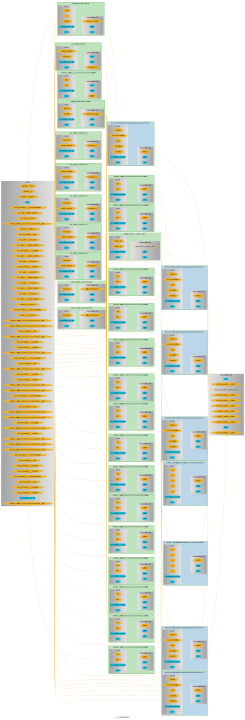

In [16]:
wf.draw(size=(10,10))

# Final execution

{'input_generator_0__dict': {'structure': '{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.04, 0.0, 0.0], [0.0, 4.04, 0.0], [0.0, 0.0, 4.04]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.02, 2.02], [2.02, 0.0, 2.02], [2.02, 2.02, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structure_features": []}',
  'pse

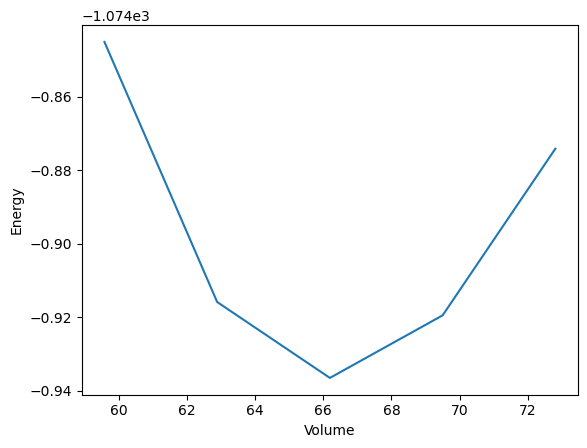

In [17]:
wf.run()